In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
#from matplotlib.patches import Arc
#from matplotlib.patches import Polygon
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

In [2]:
data_folder = 'data/'
def get_combined_frame_file(season):
    '''
    Returns the path object for the combined (live feed + html report) data frame.
    This makes no guarantees on whether the file actually exists - the object will refer to the correct file if and only if
    the file already exists.
    
    Parameters:
        season (str) - season (str) - The season for the frame. Example: '20182019' for the 2018-2019 season.
        
    Returns:
        Path object giving the absolute path to where the file should be located.
    '''
    current_dir = Path.cwd()
    relative_path = data_folder + 'combined_' + season + '.pkl'
    file = current_dir.joinpath(relative_path)
    return file

def read_combined_frame(season):
    '''
    Reads the Pandas data frame combining the live feed and the play-by-play html reports for a season, if it exists.

    Parameters:
        season (str) - The season for the frame. Example: '20182019' for the 2018-2019 season.
        
    Returns:
        Pandas data frame representing the season if it exists.
        Returns None otherwise.    
    '''
    file = get_combined_frame_file(season)
    if file.exists():
        season_frame = pd.read_pickle(str(file))
        return season_frame
    else:
        return None

In [3]:
df = read_combined_frame('20182019')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160058 entries, 10184 to 170424
Data columns (total 59 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   game_id          160058 non-null  object 
 1   season           160058 non-null  object 
 2   type             160032 non-null  object 
 3   away_id          160032 non-null  float64
 4   away_code        160032 non-null  object 
 5   home_id          160032 non-null  float64
 6   home_code        160032 non-null  object 
 7   venue            160032 non-null  object 
 8   venue_id         130908 non-null  object 
 9   game_time        160032 non-null  object 
 10  game_end_time    159919 non-null  object 
 11  game_state       160032 non-null  object 
 12  event_idx        160032 non-null  float64
 13  event_id         160032 non-null  float64
 14  period           160058 non-null  float64
 15  period_ord       160032 non-null  object 
 16  period_type      160032 non-null  

In [6]:
df.secondary_type.unique()

array(['Backhand', 'Snap Shot', 'Wrist Shot', None, 'Wrap-around',
       'Slap Shot', 'Tip-In', 'Deflected', nan], dtype=object)

In [7]:
img = mpimg.imread('NHL_Hockey_Rink.png')

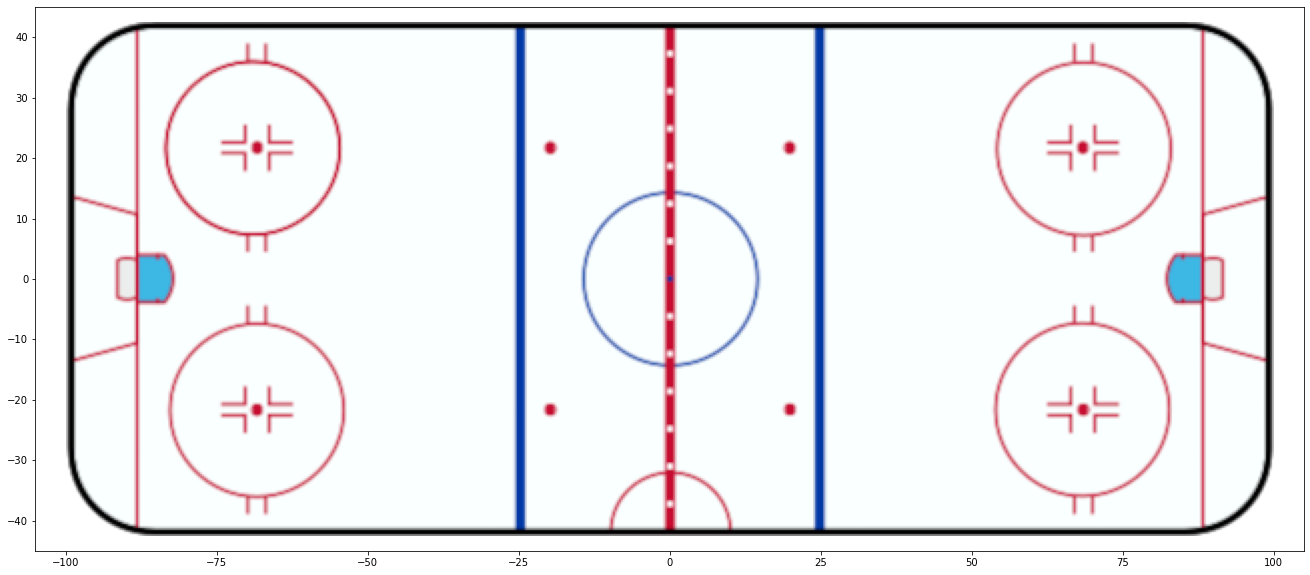

In [8]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

In [9]:
df.event_shortcode.unique()

array(['SHOT', 'BLOCK', 'MISS', 'GOAL', nan], dtype=object)

In [10]:
filter = df['event_shortcode'].notna()
df = df[filter]

In [11]:
df['event_shortcode'].unique()

array(['SHOT', 'BLOCK', 'MISS', 'GOAL'], dtype=object)

In [12]:
# Block information lacks shot location
df = df[df['event_shortcode'] != 'BLOCK']

In [13]:
df['event_shortcode'].unique()

array(['SHOT', 'MISS', 'GOAL'], dtype=object)

In [14]:
df['period_ord'].unique()

array(['1st', '2nd', '3rd', 'OT', 'SO', '2OT'], dtype=object)

In [15]:
# Shootout is 1 player vs goalie, not part of this analysis
df = df[df['period_ord'] != 'SO']

In [16]:
df['period_ord'].unique()

array(['1st', '2nd', '3rd', 'OT', '2OT'], dtype=object)

In [17]:
df = df[df['event_coord_x'].notna()]
df = df[df['event_coord_y'].notna()]

In [18]:
df['is_penalty_shot'].unique()

array([False,  True])

In [19]:
# Penalty shots are similar to shootouts. We also should exclude those.
df = df[df['is_penalty_shot']==False]

In [20]:
df['is_penalty_shot'].unique()

array([False])

In [21]:
df['hom_plr'].unique()

array([6., 5., 4., 7.])

In [22]:
# 7 players on ice is not allowed. That data must be bad.
df = df[df['hom_plr']!=7]

In [23]:
df['hom_plr'].unique()

array([6., 5., 4.])

In [24]:
df['vis_plr'].unique()

array([6., 5., 4., 2., 7.])

In [25]:
# Again, eliminate 7 players. 2 players is also not allowed.
df = df[df['vis_plr']!=7]
df = df[df['vis_plr']!=2]  

In [26]:
df['vis_plr'].unique()

array([6., 5., 4.])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118267 entries, 10184 to 170398
Data columns (total 59 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   game_id          118267 non-null  object 
 1   season           118267 non-null  object 
 2   type             118267 non-null  object 
 3   away_id          118267 non-null  float64
 4   away_code        118267 non-null  object 
 5   home_id          118267 non-null  float64
 6   home_code        118267 non-null  object 
 7   venue            118267 non-null  object 
 8   venue_id         96763 non-null   object 
 9   game_time        118267 non-null  object 
 10  game_end_time    118183 non-null  object 
 11  game_state       118267 non-null  object 
 12  event_idx        118267 non-null  float64
 13  event_id         118267 non-null  float64
 14  period           118267 non-null  float64
 15  period_ord       118267 non-null  object 
 16  period_type      118267 non-null  

In [28]:
# Now, start to build game state info
df['shooter_is_home'] = (df['event_team_code']==df['home_code'])
df['off_plr'] = np.where(df['shooter_is_home'] == True, df['hom_plr'], df['vis_plr'])
df['def_plr'] = np.where(df['shooter_is_home'] == False, df['hom_plr'], df['vis_plr'])
df['off_skr'] = np.where(df['shooter_is_home'] == True, df['hom_skr'], df['vis_skr'])
df['def_skr'] = np.where(df['shooter_is_home'] == False, df['hom_skr'], df['vis_skr'])
df['is_empty_net'] = np.where(df['shooter_is_home'] == True, df['vis_g']==0, df['hom_g']==0)
df['is_extra_attacker'] = np.where(df['shooter_is_home'] == True, df['hom_g']==0, df['vis_g']==0)
df['state'] = df['off_skr'].astype(int).astype(str) + '-' + df['def_skr'].astype(int).astype(str)

In [29]:
df['state'].value_counts()

5-5    93854
5-4    15172
4-5     3012
6-5     2055
4-4     1357
3-3     1191
5-6      637
5-3      447
6-4      243
4-3      227
4-6       47
3-4       12
3-5        9
6-3        4
Name: state, dtype: int64

In [30]:
# Subset data for display
shot_chart = df[['type', 'event_shortcode', 'event_coord_x', 'event_coord_y', 'state', 'secondary_type', 'is_empty_net', 'is_extra_attacker']].reset_index()

In [31]:
shot_chart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118267 entries, 0 to 118266
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              118267 non-null  int64 
 1   type               118267 non-null  object
 2   event_shortcode    118267 non-null  object
 3   event_coord_x      118267 non-null  object
 4   event_coord_y      118267 non-null  object
 5   state              118267 non-null  object
 6   secondary_type     85855 non-null   object
 7   is_empty_net       118267 non-null  bool  
 8   is_extra_attacker  118267 non-null  bool  
dtypes: bool(2), int64(1), object(6)
memory usage: 6.5+ MB


In [32]:
shot_chart['is_goal'] = np.where(shot_chart['event_shortcode']=='GOAL', 1, 0)

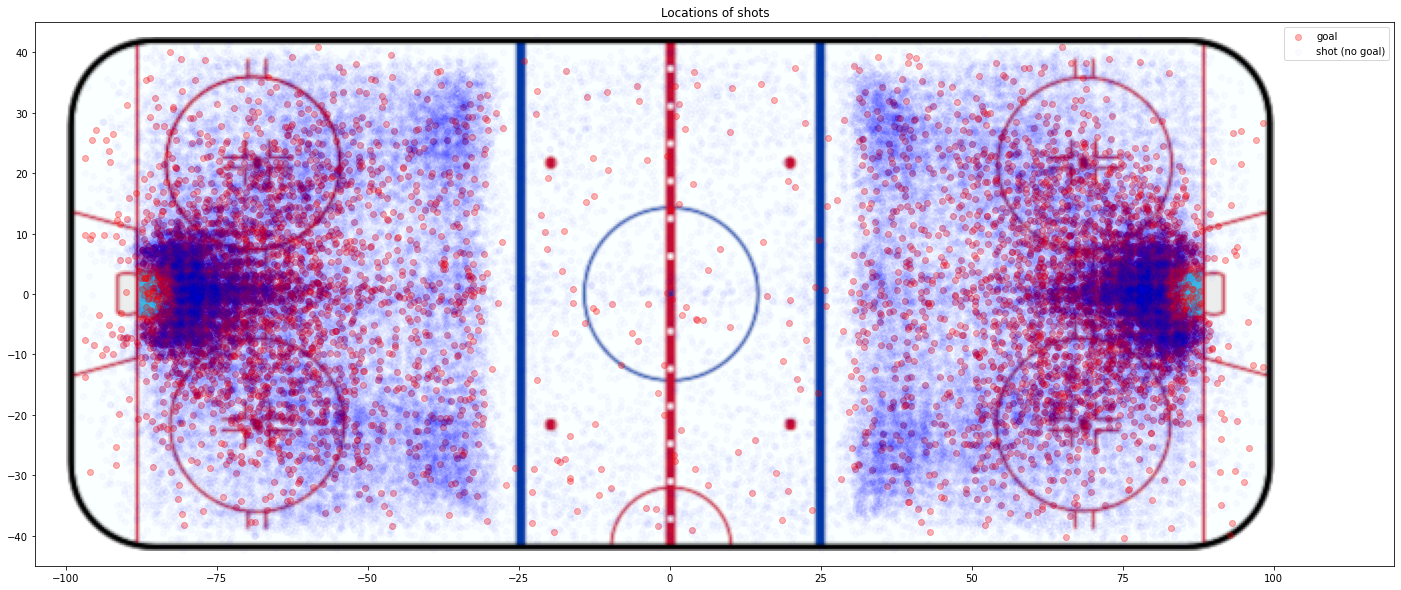

In [33]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where(shot_chart['is_goal']==1,shot_chart['event_coord_x'],None), 
            y=np.where(shot_chart['is_goal']==1,shot_chart['event_coord_y'],None), 
            c='red', alpha=0.3, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.scatter(x=np.where(shot_chart['is_goal']==0,shot_chart['event_coord_x'],None), 
            y=np.where(shot_chart['is_goal']==0,shot_chart['event_coord_y'],None), 
            c='blue', alpha=0.02, label='shot (no goal)');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of shots');
plt.legend();

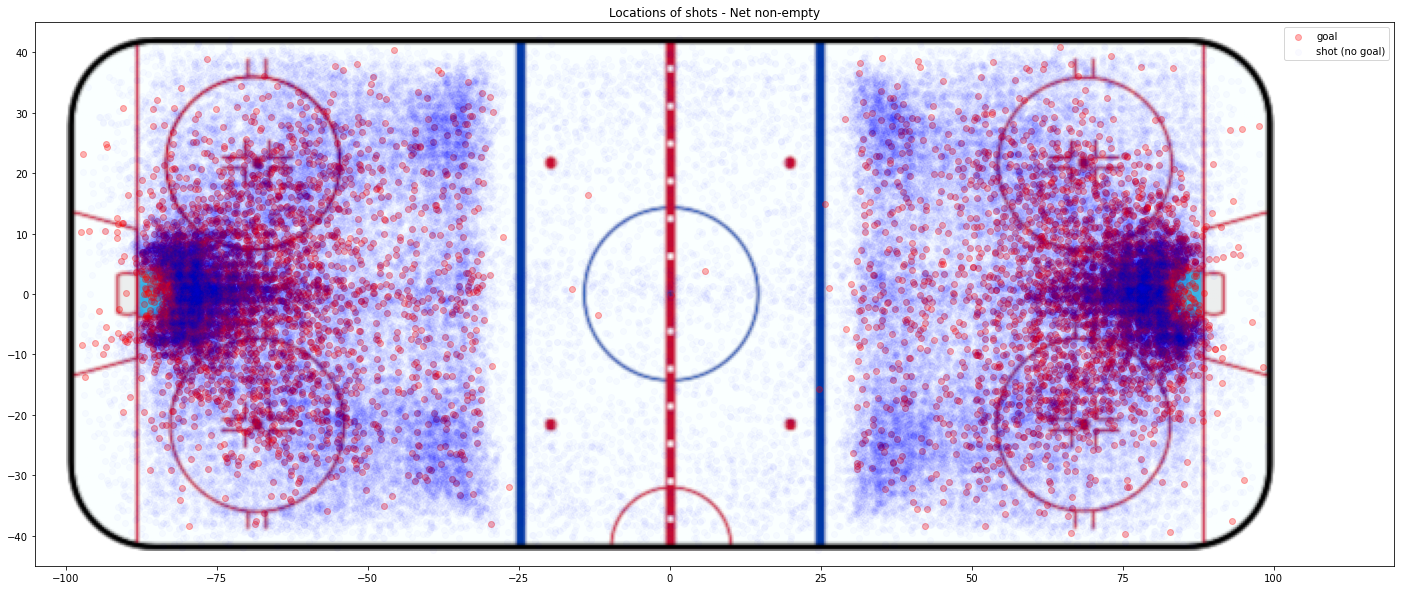

In [34]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shot_chart['is_goal']==1) & (shot_chart['is_empty_net']==False),shot_chart['event_coord_x'],None), 
            y=np.where((shot_chart['is_goal']==1) & (shot_chart['is_empty_net']==False),shot_chart['event_coord_y'],None), 
            c='red', alpha=0.3, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.scatter(x=np.where((shot_chart['is_goal']==0) & (shot_chart['is_empty_net']==False),shot_chart['event_coord_x'],None), 
            y=np.where((shot_chart['is_goal']==0) & (shot_chart['is_empty_net']==False),shot_chart['event_coord_y'],None), 
            c='blue', alpha=0.02, label='shot (no goal)');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of shots - Net non-empty');
plt.legend();

In [35]:
shot_location_percentages = shot_chart[['event_coord_x', 'event_coord_y', 'is_goal']].groupby(['event_coord_x', 'event_coord_y']).mean().reset_index()
shot_location_pivot = shot_location_percentages.pivot(columns='event_coord_x',index='event_coord_y').fillna(0)

In [36]:
shot_location_pivot.sample(20)

is_goal                                                    \
event_coord_x   -97.0 -96.0 -95.0 -94.0 -93.0     -92.0     -91.0 -90.0   
event_coord_y                                                             
-41.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-42.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 35.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-12.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 21.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-28.0             0.0   0.0   0.0   0.0   0.0  0.333333  0.000000  0.00   
 12.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.666667  0.25   
 19.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 1.0              0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-16.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 2.0              0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 42.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-18.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 8.0              0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
 3.0              0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-7.0              0.0   0.0   0.0   0.0   0.0  0.333333  0.200000  0.30   
 32.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-40.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-35.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   
-27.0             0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.00   

                               ...                                            \
event_coord_x     -89.0 -88.0  ...  90.0  91.0  92.0  93.0  94.0  95.0  96.0   
event_coord_y                  ...                                             
-41.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-42.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 35.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-12.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 21.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-28.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 12.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 19.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 1.0           0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-16.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 2.0           0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 42.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-18.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 8.0           0.000000   0.0  ...   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
 3.0           0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-7.0           0.166667   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 32.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
-40.0          0.000000   0.0  ...   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
-35.0          0.000000   0.0  ...   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
-27.0          0.000000   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                 
event_coord_x  97.0  98.0  99.0  
event_coord_y                    
-41.0           0.0   0.0   0.0  
-42.0           0.0   0.0   0.0  
 35.0           0.0   0.0   0.0  
-12.0           1.0   1.0   0.0  
 21.0           0.0   0.0   0.0  
-28.0           0.0   0.0   0.0  
 12.0           0.0   0.0   0.0  
 19.0           0.0   0.0   0.0  
 1.0            0.0   0.0   0.0  
-16.0           0.0   0.0   0.0  
 2.0 

In [37]:
goal_percentage = shot_chart['is_goal'].mean()
print(goal_percentage)

0.06799022550669248


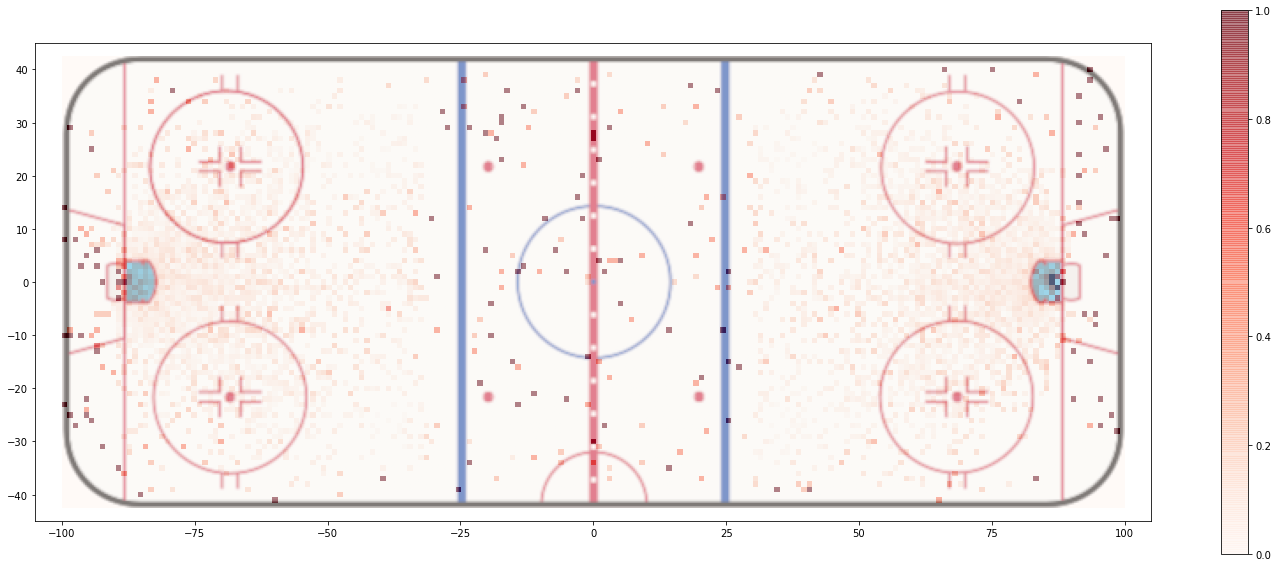

In [38]:
custom = {'red':   [(0.0,  0.0, 0.0),
                   (goal_percentage,  0.5, 0.5),
                   (0.5,  0.9, 0.9), 
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)],

         'blue':  [(0.0,  1.0, 1.0),
                   (goal_percentage,  0.5, 0.5),
                   (0.5,  0.1, 0.1), 
                   (1.0,  0.0, 0.0)],
         
         'alpha': [(0.0, 0.00, 0.00),
                   (goal_percentage, 0.70, 0.70),
                   (0.5, 0.80, 0.80),
                   (1.0, 0.95, 0.95)]
         }
my_cmap = LinearSegmentedColormap('custom_cmap',segmentdata=custom, N=256)

fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
hmax = plt.imshow(shot_location_pivot, cmap='Reds', alpha=0.5, zorder = 2, extent=(-100,100,-42.5,42.5))
plt.imshow(img, origin='lower', zorder = 1, extent = (-100,100,-42.5,42.5));
cb = plt.colorbar(hmax)
plt.show()

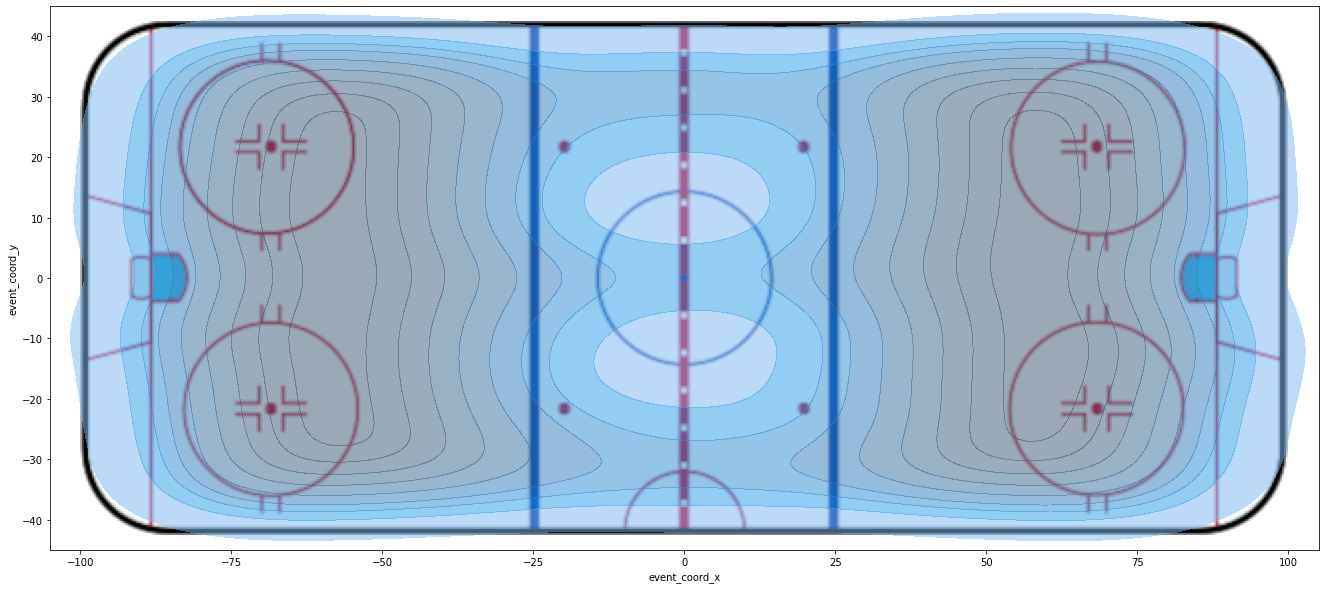

In [39]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,105))
ax.set_ylim((-45,45))
hmax = sns.kdeplot(data=shot_location_percentages, x="event_coord_x", y="event_coord_y", zorder = 2, fill=True, alpha=0.5)
plt.imshow(img, origin='lower', zorder = 1, extent = (-100,100,-42.5,42.5));